# TF-MoDISCo analysis of terminator sequences

## Import modules and define functions

Import the required modules:

In [1]:
import pathlib
import numpy as np
import pandas as pd
import modiscolite
import logomaker
import matplotlib
from matplotlib import pyplot as plt

Monkey-patch TF-MoDISCo to not consider rev-comp alignments:

In [2]:
import sklearn
from numba import njit
from numba import prange

def _align_patterns_noRC(parent_pattern, child_pattern, metric, min_overlap, 
	transformer, include_hypothetical):

	fwd_data_parent, rev_data_parent = modiscolite.util.get_2d_data_from_patterns(
		[parent_pattern], transformer=transformer,
		include_hypothetical=include_hypothetical)

	fwd_data_child, rev_data_child = modiscolite.util.get_2d_data_from_patterns(
		[child_pattern], transformer=transformer,
		include_hypothetical=include_hypothetical)

	best_crossmetric, best_crossmetric_argmax = metric(fwd_data_child, 
		fwd_data_parent, min_overlap).squeeze()

	return int(best_crossmetric_argmax), False, best_crossmetric

modiscolite.aggregator._align_patterns = _align_patterns_noRC



def jaccard_from_seqlets_noRC(seqlets, min_overlap, filter_seqlets=None, 
	seqlet_neighbors=None):

	all_fwd_data, all_rev_data = modiscolite.util.get_2d_data_from_patterns(seqlets)

	if filter_seqlets is None:
		filter_seqlets = seqlets
		filters_all_fwd_data = all_fwd_data
		filters_all_rev_data = all_rev_data
	else:
		filters_all_fwd_data, filters_all_rev_data = modiscolite.util.get_2d_data_from_patterns(filter_seqlets)

	if seqlet_neighbors is None:
		seqlet_neighbors = [list(range(len(filter_seqlets)))
							for x in seqlets] 

	#apply the cross metric
	affmat = modiscolite.affinitymat.jaccard(seqlet_neighbors=seqlet_neighbors, 
		X=filters_all_fwd_data,
		Y=all_fwd_data, min_overlap=min_overlap, func=int, 
		return_sparse=True)

	return affmat

modiscolite.affinitymat.jaccard_from_seqlets = jaccard_from_seqlets_noRC



@njit(parallel=True)
def _sparse_mm_dot_noRC(X_data, X_indices, X_indptr, k):
	n_rows = len(X_indptr) - 1

	neighbors = np.empty((n_rows, k), dtype='int32')
	sims = np.empty((n_rows, k), dtype='float64')

	for i in prange(n_rows):
		dot = np.zeros(n_rows, dtype='float64')

		for j in range(n_rows):
			dot[j] = modiscolite.affinitymat._sparse_vv_dot(X_data, X_indices, X_indptr, X_data, X_indices, X_indptr, i, j)

		dot_argsort = np.argsort(-dot, kind='mergesort')[:k]
		neighbors[i] = dot_argsort
		sims[i] = dot[dot_argsort]

	return sims, neighbors

def cosine_similarity_from_seqlets_noRC(seqlets, n_neighbors, sign, topn=20, 
	min_k=4, max_k=6, max_gap=15, max_len=15, max_entries=500, 
	alphabet_size=4):

	X_fwd = modiscolite.gapped_kmer._seqlet_to_gkmers(seqlets, topn, 
		min_k, max_k, max_gap, max_len, max_entries, True, sign)

	X = sklearn.preprocessing.normalize(X_fwd, norm='l2', axis=1)

	n, d = X.shape
	k = min(n_neighbors+1, n)
	return _sparse_mm_dot_noRC(X.data, X.indices, X.indptr, k)

modiscolite.affinitymat.cosine_similarity_from_seqlets = cosine_similarity_from_seqlets_noRC

Function to plot motifs:

In [3]:
%matplotlib inline

def plot_motif(pattern, trim_threshold = 0.25, pad_motif = 0, fig_size = (5, 1.5), file = None):
  # trim motif
  if trim_threshold > 0:
    max_score = np.sum(np.abs(pattern), axis = 1)
    trim_thresh = np.max(max_score) * trim_threshold
    pass_inds = np.where(max_score >= trim_thresh)[0]
    trimmed_start, trimmed_end = max(np.min(pass_inds) - pad_motif, 0), min(np.max(pass_inds) + pad_motif + 1, len(max_score) + 1)
    pattern = pattern[trimmed_start:trimmed_end]

  # plot motif
  fig = plt.figure(figsize = fig_size)
  ax = fig.add_subplot(111) 

  df = pd.DataFrame(pattern, columns = ['A', 'C', 'G', 'U'])
  df.index.name = 'pos'

  crp_logo = logomaker.Logo(df, ax = ax)
  crp_logo.style_spines(visible = False)

  if file is not None:
    plt.savefig(file)

Create a directory for the output files:

In [4]:
pathlib.Path('modisco').mkdir(exist_ok = True)

## Load data

Load one-hot encoded sequences:

In [5]:
ohe_seqs = np.load('ohe_seqs.npz')['arr_0'].transpose(0, 2, 1)

Load feature attributions:

In [6]:
DL_imps_tobacco = np.load('DeepLift_imps_tobacco.npz')['arr_0'].transpose(0, 2, 1)
DL_imps_maize = np.load('DeepLift_imps_maize.npz')['arr_0'].transpose(0, 2, 1)

## Run TF-MoDISCo

Setup:

In [7]:
window_size = 20
flank = 5
fdr = 0.05

Use feature attibutions from the tobacco model:

In [8]:
pos_patterns_tobacco, neg_patterns_tobacco = modiscolite.tfmodisco.TFMoDISco(
  hypothetical_contribs = DL_imps_tobacco, 
  one_hot = ohe_seqs,
  verbose = True,
  sliding_window_size = window_size, 
	flank_size = flank,
  target_seqlet_fdr = fdr
  )

Using 1919 positive seqlets
Extracted 2142 negative seqlets


Use feature attibutions from the maize model:

In [9]:
pos_patterns_maize, neg_patterns_maize = modiscolite.tfmodisco.TFMoDISco(
  hypothetical_contribs = DL_imps_maize, 
  one_hot = ohe_seqs,
  verbose = True,
  sliding_window_size = window_size, 
	flank_size = flank,
  target_seqlet_fdr = fdr
  )

Using 1298 positive seqlets
Extracted 2858 negative seqlets


## Plot motifs:

Motifs that **increase** terminator strength in tobacco leaves:

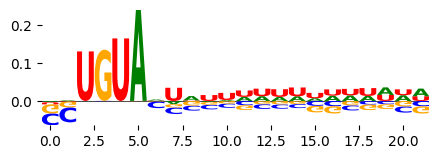

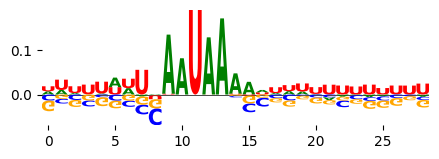

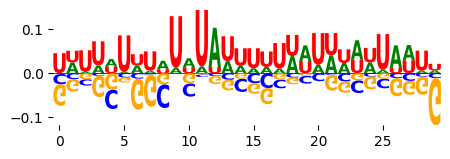

In [10]:
for idx, pattern in enumerate(pos_patterns_tobacco):
    plot_motif(pattern.contrib_scores, file = f'modisco/pos_motif_tobacco_{idx}.pdf')

Motifs that **decrease** terminator strength in tobacco leaves:

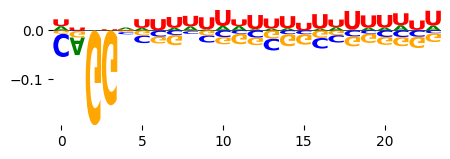

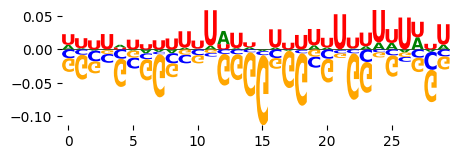

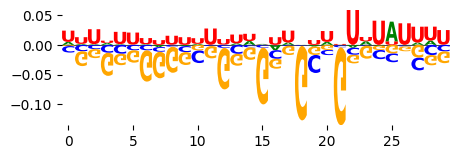

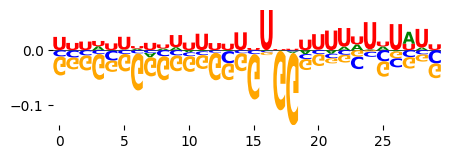

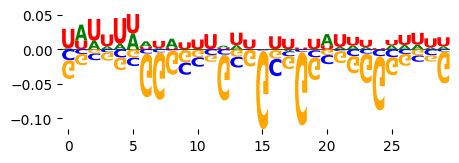

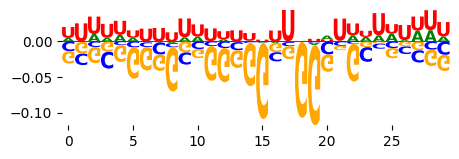

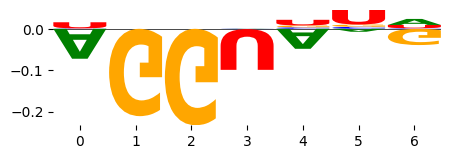

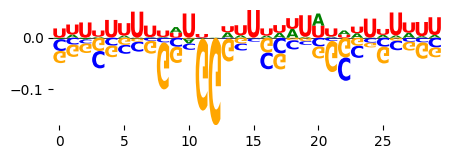

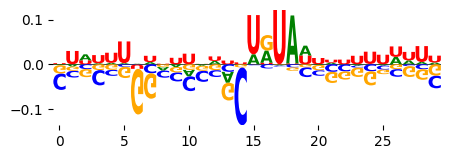

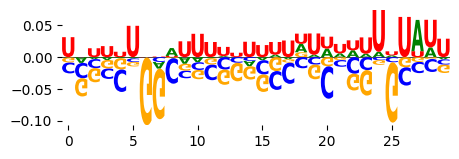

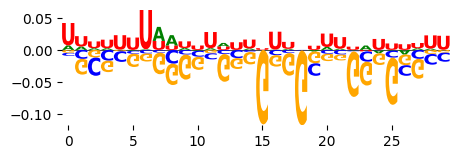

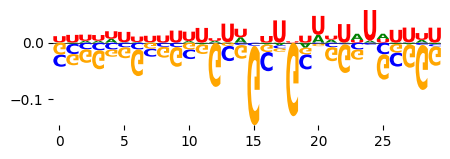

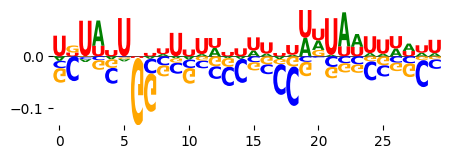

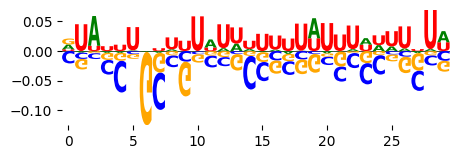

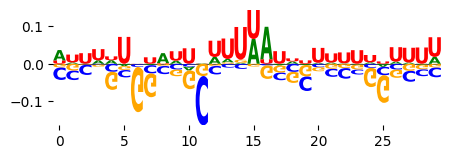

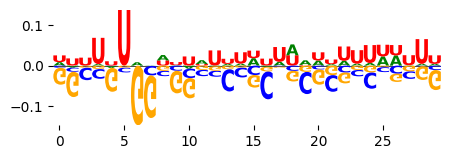

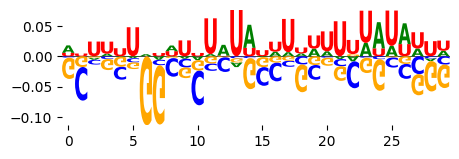

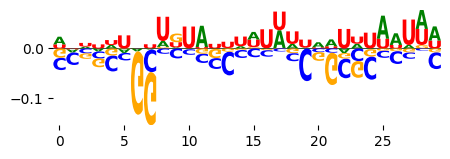

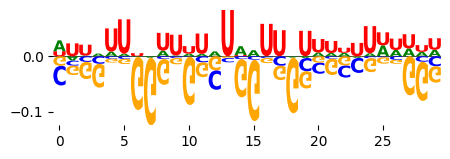

In [11]:
for idx, pattern in enumerate(neg_patterns_tobacco):
    plot_motif(pattern.contrib_scores, file = f'modisco/neg_motif_tobacco_{idx}.pdf')

Motifs that **increase** terminator strength in maize protoplasts:

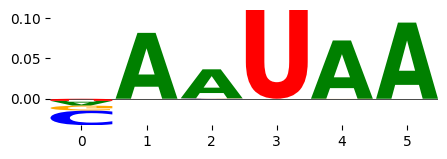

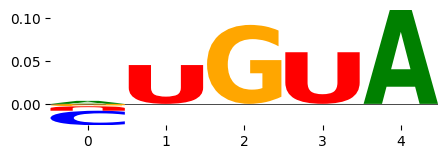

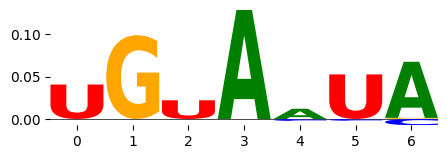

In [12]:
for idx, pattern in enumerate(pos_patterns_maize):
    plot_motif(pattern.contrib_scores, file = f'modisco/pos_motif_maize_{idx}.pdf')

Motifs that **decrease** terminator strength in maize protoplasts:

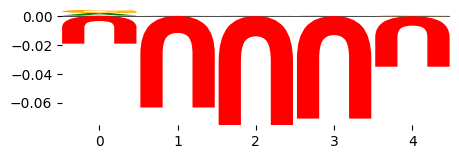

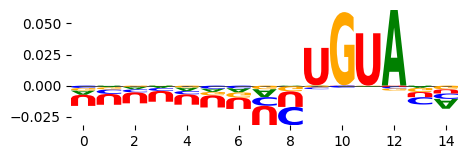

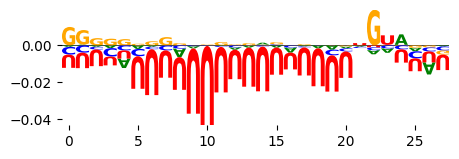

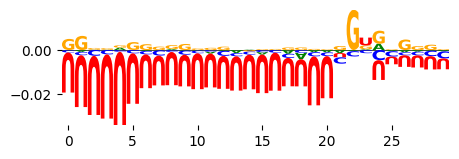

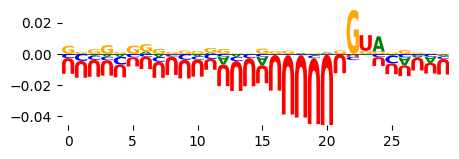

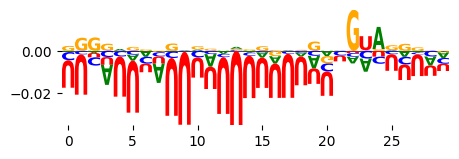

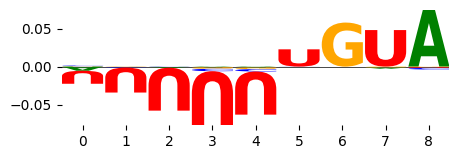

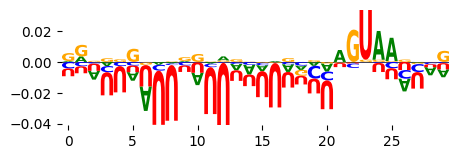

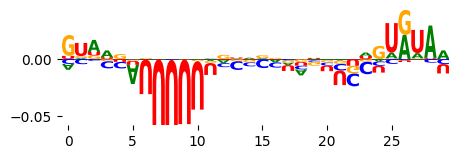

In [13]:
for idx, pattern in enumerate(neg_patterns_maize):
    plot_motif(pattern.contrib_scores, file = f'modisco/neg_motif_maize_{idx}.pdf')